In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np

# You need to have your model class definition available
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import pandas as pd

# ==================== BIOLOGICAL PRIOR CLASSES ====================
class BiologicalPriorLayer(nn.Module):
    def __init__(self, feature_names, prior_type='transcriptome'):
        super().__init__()
        self.register_buffer('mask', self._create_mask(feature_names, prior_type))

    def _create_mask(self, feature_names, prior_type):
        mask = torch.ones(len(feature_names))

        if prior_type == 'transcriptome':
            for i, gene in enumerate(feature_names):
                if any(target in gene for target in ['VIT', 'FER', 'IRT']):
                    mask[i] = 2.0
                elif any(target in gene for target in ['JAZ', 'MYC', 'COI']):
                    mask[i] = 1.5
                elif 'U2AF' in gene or 'SR45' in gene:
                    mask[i] = 1.8

        elif prior_type == 'metabolite':
            for i, metab in enumerate(feature_names):
                if metab in ['JA-Ile', 'SA']:
                    mask[i] = 2.0
                elif 'tomatine' in metab:
                    mask[i] = 1.5
                elif metab in ['Citrate', 'Malate']:
                    mask[i] = 1.3

        return mask

    def forward(self, x):
        return x * self.mask

class PathwayGuidedAttention(nn.Module):
    def __init__(self, query_dim, kv_dim, output_dim):
        super().__init__()
        self.query = nn.Linear(query_dim, output_dim)
        self.key = nn.Linear(kv_dim, output_dim)
        self.value = nn.Linear(kv_dim, output_dim)
        self.bio_scale = nn.Parameter(torch.tensor(1.0))
        self.attn_dropout = nn.Dropout(0.1)
        self.output_dim = output_dim

    def forward(self, x1, x2):
        if x1.dim() == 2:
            x1 = x1.unsqueeze(1)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(1)

        Q = self.query(x1)
        K = self.key(x2)
        V = self.value(x2)

        attn_scores = torch.bmm(Q, K.transpose(1, 2)) * torch.sigmoid(self.bio_scale)
        scale = torch.sqrt(torch.tensor(self.output_dim, dtype=torch.float32, device=Q.device))
        attn_weights = F.softmax(attn_scores / scale, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        return torch.bmm(attn_weights, V).squeeze(1)

# ==================== CoMM_BIP MODEL CLASS ====================
class CoMM_BIP(pl.LightningModule):
    def __init__(self, input_dims, feature_names, temperature=0.1):
        super().__init__()
        self.save_hyperparameters()

        # Architecture
        self.temperature = nn.Parameter(torch.ones(1))  # For calibration

        # Enhanced confidence thresholds
        self.confidence_thresholds = {
            'low': (0.0, 0.6),
            'medium': (0.6, 0.75),
            'high': (0.75, 0.92),
            'vhigh': (0.92, 1.0)
        }

        # Track confidence distribution
        self.confidence_bins = np.linspace(0, 1, 21)

        # Initialize loss functions
        self.classification_loss = nn.CrossEntropyLoss(label_smoothing=0.2)

        # Temperature parameter for calibration
        self.temperature = nn.Parameter(torch.ones(1))

        # Initialize your model architecture components here
        self.dropout = nn.Dropout(0.5)

        # Encoders
        self.rna_encoder = nn.Sequential(
            BiologicalPriorLayer(feature_names['rna'], 'transcriptome'),
            nn.Linear(input_dims['rna'], 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128)
        )

        self.metabo_encoder = nn.Sequential(
            BiologicalPriorLayer(feature_names['metabo'], 'metabolite'),
            nn.Linear(input_dims['metabo'], 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64)
        )

        self.pheno_encoder = nn.Sequential(
            nn.Linear(input_dims['pheno'], 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32)
        )

        self.env_encoder = nn.Sequential(
            nn.Linear(input_dims['env'], 32),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        # Attention modules
        self.rna_metabo_attn = PathwayGuidedAttention(128, 64, 128)
        self.pheno_env_attn = PathwayGuidedAttention(32, 32, 32)

        # Projection heads
        self.rna_proj = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Linear(64, 32)
        )

        self.metabo_proj = nn.Sequential(
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 32)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 + 64 + 32 + 32 + 128 + 32, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self, module=None):
        if module is None:
            for module in self.modules():
                self._init_weights(module)
            return

        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def encode(self, rna, metabo, pheno, env):
        h_rna = self.rna_encoder(rna)
        h_metabo = self.metabo_encoder(metabo)
        h_pheno = self.pheno_encoder(pheno)
        h_env = self.env_encoder(env)

        h_rna_metabo = self.rna_metabo_attn(
            h_rna.unsqueeze(1),
            h_metabo.unsqueeze(1)
        )
        h_pheno_env = self.pheno_env_attn(
            h_pheno.unsqueeze(1),
            h_env.unsqueeze(1)
        )

        return h_rna, h_metabo, h_pheno, h_env, h_rna_metabo, h_pheno_env

    def forward(self, rna, metabo, pheno, env):
        h_rna, h_metabo, h_pheno, h_env, h_rna_metabo, h_pheno_env = self.encode(rna, metabo, pheno, env)
        joint = torch.cat([h_rna, h_metabo, h_pheno, h_env, h_rna_metabo, h_pheno_env], dim=1)
        logits = self.classifier(joint)

        return logits / torch.clamp(self.temperature, min=1e-3)

    def get_attention_weights(self, rna, metabo, pheno, env):
        """Extract attention weights for analysis"""
        attention_weights = {}

        # Get encodings
        h_rna = self.rna_encoder(rna)
        h_metabo = self.metabo_encoder(metabo)
        h_pheno = self.pheno_encoder(pheno)
        h_env = self.env_encoder(env)

        # Calculate RNA-Metabo attention
        Q_rm = self.rna_metabo_attn.query(h_rna.unsqueeze(1))
        K_rm = self.rna_metabo_attn.key(h_metabo.unsqueeze(1))
        attn_scores_rm = torch.bmm(Q_rm, K_rm.transpose(1, 2)) * torch.sigmoid(self.rna_metabo_attn.bio_scale)
        scale_rm = torch.sqrt(torch.tensor(self.rna_metabo_attn.output_dim, dtype=torch.float32))
        attention_weights['rna_metabo'] = F.softmax(attn_scores_rm / scale_rm, dim=-1).squeeze().cpu().numpy()

        # Calculate Pheno-Env attention
        Q_pe = self.pheno_env_attn.query(h_pheno.unsqueeze(1))
        K_pe = self.pheno_env_attn.key(h_env.unsqueeze(1))
        attn_scores_pe = torch.bmm(Q_pe, K_pe.transpose(1, 2)) * torch.sigmoid(self.pheno_env_attn.bio_scale)
        scale_pe = torch.sqrt(torch.tensor(self.pheno_env_attn.output_dim, dtype=torch.float32))
        attention_weights['pheno_env'] = F.softmax(attn_scores_pe / scale_pe, dim=-1).squeeze().cpu().numpy()

        return attention_weights

# ==================== MODEL LOADING FUNCTION ====================
def load_commbip_model_correctly(model_path):
    """Load your CoMM_BIP model with the correct architecture"""

    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')
    print("✓ Checkpoint loaded successfully")

    # Extract components
    model_state = checkpoint['model_state']
    feature_names = checkpoint['feature_names']
    input_dims = checkpoint['input_dims']

    print(f"✓ Model state: {len(model_state)} parameters")
    print(f"✓ Feature names: {list(feature_names.keys())}")
    print(f"✓ Input dimensions: {input_dims}")

    # Recreate the model with exact same architecture
    model = CoMM_BIP(
        input_dims=input_dims,
        feature_names=feature_names
    )

    # Handle potential shape mismatch for 'temperature'
    # The checkpoint might save 'temperature' as a scalar (shape torch.Size([]))
    # while the model expects a tensor of shape torch.Size([1]).
    if 'temperature' in model_state and model_state['temperature'].shape == torch.Size([]):
        model_state['temperature'] = model_state['temperature'].unsqueeze(0)
    # If 'model_state.temperature_param' exists and is a scalar, handle it too
    if 'temperature_param' in model_state and model_state['temperature_param'].shape == torch.Size([]):
        model_state['temperature_param'] = model_state['temperature_param'].unsqueeze(0)

    # Load the state dict
    model.load_state_dict(model_state)
    model.eval()

    print("✓ Model loaded and ready for inference!")
    return model, feature_names, input_dims

# USAGE:
model, feature_names, input_dims = load_commbip_model_correctly('commbip_final_model.pt')


✓ Checkpoint loaded successfully
✓ Model state: 53 parameters
✓ Feature names: ['rna', 'metabo', 'pheno']
✓ Input dimensions: {'rna': 27388, 'metabo': 20, 'pheno': 9, 'env': 1}
✓ Model loaded and ready for inference!


In [3]:
model

CoMM_BIP(
  (classification_loss): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
  (rna_encoder): Sequential(
    (0): BiologicalPriorLayer()
    (1): Linear(in_features=27388, out_features=256, bias=True)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): GELU(approximate='none')
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
  )
  (metabo_encoder): Sequential(
    (0): BiologicalPriorLayer()
    (1): Linear(in_features=20, out_features=128, bias=True)
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): GELU(approximate='none')
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
  )
  (pheno_encoder): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_featur

In [25]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from torch.utils.data import Dataset, DataLoader

# First, let's explore your H5 file structure
def explore_h5_file(h5_file_path):
    """Explore the structure of the H5 file"""
    print(f"Exploring H5 file: {h5_file_path}")

    def print_h5_structure(name, obj):
        print(f"{name}: {type(obj)}")
        if isinstance(obj, h5py.Dataset):
            print(f"    Shape: {obj.shape}, Dtype: {obj.dtype}")

    with h5py.File(h5_file_path, 'r') as f:
        print("H5 file structure:")
        f.visititems(print_h5_structure)

        # Try to find available splits
        print("\nAvailable keys in root:")
        for key in f.keys():
            print(f"  - {key}")

        # If there are groups, explore them
        for key in f.keys():
            if isinstance(f[key], h5py.Group):
                print(f"\nContents of group '{key}':")
                for subkey in f[key].keys():
                    print(f"  - {subkey}: {f[key][subkey].shape}")

# Run exploration
h5_file_path = "selected_data_27388.h5"
explore_h5_file(h5_file_path)

Exploring H5 file: selected_data_27388.h5
H5 file structure:
environment: <class 'h5py._hl.group.Group'>
environment/axis0: <class 'h5py._hl.dataset.Dataset'>
    Shape: (5,), Dtype: |S44
environment/axis1: <class 'h5py._hl.dataset.Dataset'>
    Shape: (16,), Dtype: |S5
environment/block0_items: <class 'h5py._hl.dataset.Dataset'>
    Shape: (5,), Dtype: |S44
environment/block0_values: <class 'h5py._hl.dataset.Dataset'>
    Shape: (16, 5), Dtype: float64
metabolomics: <class 'h5py._hl.group.Group'>
metabolomics/axis0: <class 'h5py._hl.dataset.Dataset'>
    Shape: (18,), Dtype: |S19
metabolomics/axis1: <class 'h5py._hl.dataset.Dataset'>
    Shape: (16,), Dtype: |S5
metabolomics/block0_items: <class 'h5py._hl.dataset.Dataset'>
    Shape: (18,), Dtype: |S19
metabolomics/block0_values: <class 'h5py._hl.dataset.Dataset'>
    Shape: (16, 18), Dtype: float64
phenomics: <class 'h5py._hl.group.Group'>
phenomics/axis0: <class 'h5py._hl.dataset.Dataset'>
    Shape: (7,), Dtype: |S27
phenomics/axis

In [27]:
def load_all_datasets_with_transcriptome_selection(h5_file_path, target_size=27388, random_seed=42):
    """Load all datasets and select random transcriptome features"""

    np.random.seed(random_seed)
    data = {}

    with h5py.File(h5_file_path, 'r') as f:
        # Load transcriptome with selection
        transcriptome_values = f['transcriptome/block0_values'][:]
        transcriptome_features = [x.decode('utf-8') for x in f['transcriptome/block0_items'][:]]
        transcriptome_samples = [x.decode('utf-8') for x in f['transcriptome/axis1'][:]]

        # Randomly select features
        selected_features = np.random.choice(
            transcriptome_features,
            size=target_size,
            replace=False
        )

        # Get indices of selected features
        feature_indices = [transcriptome_features.index(f) for f in selected_features]
        selected_values = transcriptome_values[:, feature_indices]

        data['transcriptome'] = pd.DataFrame(
            selected_values,
            index=transcriptome_samples,
            columns=selected_features
        )

        # Load other datasets without modification
        for dataset_name in ['metabolomics', 'phenomics', 'environment']:
            values = f[f'{dataset_name}/block0_values'][:]
            features = [x.decode('utf-8') for x in f[f'{dataset_name}/block0_items'][:]]
            samples = [x.decode('utf-8') for x in f[f'{dataset_name}/axis1'][:]]

            data[dataset_name] = pd.DataFrame(
                values,
                index=samples,
                columns=features
            )

    # Print shapes
    for name, df in data.items():
        print(f"{name}: {df.shape}")

    return data

# Usage
all_data = load_all_datasets_with_transcriptome_selection('data_coMM_sensory.h5', target_size=27388)

# Access your data
transcriptome = all_data['transcriptome']  # Shape: (16, 27388)
metabolomics = all_data['metabolomics']    # Shape: (16, 18)
phenomics = all_data['phenomics']          # Shape: (16, 7)
environment = all_data['environment']      # Shape: (16, 3)

transcriptome: (16, 27388)
metabolomics: (16, 18)
phenomics: (16, 7)
environment: (16, 3)


In [6]:
import h5py
import torch
import torch.nn as nn

def get_feature_dimensions(h5_file_path):
    """Get feature dimensions from H5 file"""
    with h5py.File(h5_file_path, 'r') as f:
        dims = {
            'rna': f['transcriptome/block0_values'].shape[1],
            'metabo': f['metabolomics/block0_values'].shape[1],
            'pheno': f['phenomics/block0_values'].shape[1],
            'env': f['environment/block0_values'].shape[1]
        }
    return dims

def get_feature_names(h5_file_path):
    """Get feature names from H5 file"""
    with h5py.File(h5_file_path, 'r') as f:
        feature_names = {
            'rna': [x.decode('utf-8') for x in f['transcriptome/block0_items'][:]],
            'metabo': [x.decode('utf-8') for x in f['metabolomics/block0_items'][:]],
            'pheno': [x.decode('utf-8') for x in f['phenomics/block0_items'][:]],
            'env': [x.decode('utf-8') for x in f['environment/block0_items'][:]]
        }
    return feature_names

# Get correct dimensions from your H5 file
h5_dims = get_feature_dimensions("selected_data_27388.h5")
h5_feature_names = get_feature_names("selected_data_27388.h5")

print("Required dimensions for model:")
print(f"Transcriptome: {h5_dims['rna']}")
print(f"Metabolomics: {h5_dims['metabo']}")
print(f"Phenomics: {h5_dims['pheno']}")
print(f"Environment: {h5_dims['env']}")

# Recreate your model with correct dimensions
model = CoMM_BIP(
    input_dims={
        'rna': h5_dims['rna'],
        'metabo': h5_dims['metabo'],
        'pheno': h5_dims['pheno'],
        'env': h5_dims['env']
    },
    feature_names=h5_feature_names
)

print("Model created with correct dimensions!")

Required dimensions for model:
Transcriptome: 27388
Metabolomics: 18
Phenomics: 7
Environment: 5
Model created with correct dimensions!


In [28]:
import h5py
import pandas as pd
import numpy as np

# Load environment data from H5 file first
def load_environment_from_h5(h5_file_path):
    """Load environment data from H5 file and create environment_df"""
    with h5py.File(h5_file_path, 'r') as f:
        # Extract environment data
        env_values = f['environment/block0_values'][:]
        env_features = [x.decode('utf-8') for x in f['environment/block0_items'][:]]
        env_samples = [x.decode('utf-8') for x in f['environment/axis1'][:]]

        # Create environment DataFrame
        environment_df = pd.DataFrame(
            env_values,
            index=env_samples,
            columns=env_features
        )

        print(f"Loaded environment data: {environment_df.shape}")
        print(f"Environment columns: {environment_df.columns.tolist()}")

        return environment_df

# Load environment data first
h5_file_path = "selected_data_27388.h5"
environment_df = load_environment_from_h5(h5_file_path)

Loaded environment data: (16, 5)
Environment columns: ['Characteristics[age]', 'Characteristics[time]', 'Genotype', 'Effector', 'Characteristics[genotype]_wild type genotype']


In [29]:
class CoMMH5Dataset(Dataset):
    def __init__(self, h5_file_path: str, environment_df: pd.DataFrame):
        self.h5_file_path = h5_file_path
        self.environment_df = environment_df

        with h5py.File(h5_file_path, 'r') as f:
            # Get the number of samples
            self.length = f['transcriptome/block0_values'].shape[0]
            print(f"Dataset contains {self.length} samples")

            # Get feature names
            self.rna_features = [x.decode('utf-8') for x in f['transcriptome/block0_items'][:]]
            self.metabo_features = [x.decode('utf-8') for x in f['metabolomics/block0_items'][:]]
            self.pheno_features = [x.decode('utf-8') for x in f['phenomics/block0_items'][:]]
            self.env_features = [x.decode('utf-8') for x in f['environment/block0_items'][:]]

            # Get sample names from the H5 file
            h5_sample_names = [x.decode('utf-8') for x in f['environment/axis1'][:]]

            print(f"RNA features: {len(self.rna_features)}")
            print(f"Metabolite features: {len(self.metabo_features)}")
            print(f"Phenotype features: {len(self.pheno_features)}")
            print(f"Environment features: {len(self.env_features)}")

        # Verify that environment_df has the same samples as H5 file
        missing_samples = set(h5_sample_names) - set(environment_df.index)
        if missing_samples:
            print(f"Warning: {len(missing_samples)} samples missing from environment_df")

        # Align environment_df with H5 sample order
        aligned_environment_df = environment_df.loc[h5_sample_names]

        # Check if 'Effector' column exists
        if 'Effector' not in aligned_environment_df.columns:
            print("Warning: 'Effector' column not found in environment data")
            print(f"Available columns: {aligned_environment_df.columns.tolist()}")
            # Create dummy labels if Effector column doesn't exist
            self.labels = np.zeros(self.length, dtype=int)
        else:
            # Map effector names to integer labels
            current_env_effector_series = aligned_environment_df['Effector']
            unique_effectors_in_data = sorted(current_env_effector_series.unique().tolist())
            self.effector_to_label_map = {eff: i for i, eff in enumerate(unique_effectors_in_data)}
            self.label_to_effector_map = {i: eff for i, eff in enumerate(unique_effectors_in_data)}
            self.labels = np.array([self.effector_to_label_map[eff] for eff in current_env_effector_series.tolist()])

            print(f"Found {len(unique_effectors_in_data)} unique effectors: {unique_effectors_in_data}")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.h5_file_path, 'r') as f:
            sample = {
                'rna': torch.FloatTensor(f['transcriptome/block0_values'][idx]),
                'metabo': torch.FloatTensor(f['metabolomics/block0_values'][idx]),
                'pheno': torch.FloatTensor(f['phenomics/block0_values'][idx]),
                'env': torch.FloatTensor(f['environment/block0_values'][idx]),
                'target': torch.LongTensor([self.labels[idx]])
            }
        return sample

    def get_feature_names(self):
        return {
            'rna': self.rna_features,
            'metabo': self.metabo_features,
            'pheno': self.pheno_features,
            'env': self.env_features
        }

In [33]:
def extract_attention_and_priors(model, dataloader, device, feature_names):
    """
    Extract learned attention matrices and priors from the CoMM_BIP model
    """
    model.eval()

    # Store attention weights and priors
    attention_data = {}

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx >= 1:  # Just use first batch for analysis
                break

            print(f"Processing batch {batch_idx}")

            # Move batch to device
            rna_data = batch['rna'].to(device)
            metabo_data = batch['metabo'].to(device)
            pheno_data = batch['pheno'].to(device)
            env_data = batch['env'].to(device)

            print(f"RNA data shape: {rna_data.shape}")
            print(f"Metabo data shape: {metabo_data.shape}")
            print(f"Pheno data shape: {pheno_data.shape}")
            print(f"Env data shape: {env_data.shape}")

            # Extract priors from BiologicalPriorLayer
            print("Extracting biological priors...")

            # RNA prior (from rna_encoder)
            rna_prior_layer = model.rna_encoder[0]  # BiologicalPriorLayer
            if hasattr(rna_prior_layer, 'mask'): # BiologicalPriorLayer stores prior in 'mask'
                rna_prior = rna_prior_layer.mask
                if isinstance(rna_prior, torch.Tensor):
                    rna_prior = rna_prior.cpu().numpy()
                # The current BiologicalPriorLayer's mask is 1D, representing weights applied to features.
                # For 'prior matrix' for delta analysis, it implies a connection matrix.
                # Here, we will just use the learned mask as a representation of prior importance.
                # If a specific prior *matrix* was intended, the BiologicalPriorLayer would need to output it.
                # For now, let's represent it as a diagonal matrix if the original intention was direct feature weighting.
                attention_data['rna_prior_mask'] = rna_prior
                print(f"RNA prior mask shape: {rna_prior.shape}")
            else:
                print("RNA prior layer doesn't have a 'mask' attribute or get_prior_matrix method")
                # Create a placeholder prior for consistency if not found
                n_genes = rna_data.shape[1]
                attention_data['rna_prior_mask'] = np.ones(n_genes)

            # Metabo prior (from metabo_encoder)
            metabo_prior_layer = model.metabo_encoder[0]  # BiologicalPriorLayer
            if hasattr(metabo_prior_layer, 'mask'):
                metabo_prior = metabo_prior_layer.mask
                if isinstance(metabo_prior, torch.Tensor):
                    metabo_prior = metabo_prior.cpu().numpy()
                attention_data['metabo_prior_mask'] = metabo_prior
                print(f"Metabo prior mask shape: {metabo_prior.shape}")
            else:
                print("Metabo prior layer doesn't have a 'mask' attribute or get_prior_matrix method")
                n_metabolites = metabo_data.shape[1]
                attention_data['metabo_prior_mask'] = np.ones(n_metabolites)

            # Forward pass to extract attention weights
            print("Running forward pass to extract attention...")

            # Extract attention weights using the model's dedicated method
            # This method directly computes the attention scores within the model's graph
            attn_weights_dict = model.get_attention_weights(rna_data, metabo_data, pheno_data, env_data)

            attention_data['rna_metabo_attention'] = attn_weights_dict['rna_metabo']
            # The pheno_env attention is not used in the delta analysis code below, but we can store it.
            attention_data['pheno_env_attention'] = attn_weights_dict['pheno_env']

            print(f"RNA-Metabo attention shape: {attention_data['rna_metabo_attention'].shape}")
            print(f"Pheno-Env attention shape: {attention_data['pheno_env_attention'].shape}")

            # Store feature dimensions and names
            attention_data['feature_dims'] = {
                'rna': rna_data.shape[1],
                'metabo': metabo_data.shape[1],
                'pheno': pheno_data.shape[1],
                'env': env_data.shape[1]
            }
            attention_data['feature_names'] = feature_names

            # Store actual feature tensors (encoded features, not raw inputs)
            # For delta analysis, we only need the attention matrix and feature names.

    return attention_data

In [39]:
def create_cross_modal_analysis(attention_data):
    """
    Create cross-modal delta analysis for RNA-Metabo attention
    """
    feature_names = attention_data['feature_names']

    # Get RNA-Metabo attention. This should be a (num_samples, rna_features, metabo_features) or (rna_features, metabo_features) matrix
    rna_metabo_attention = attention_data['rna_metabo_attention']

    # If attention is per-sample, average across samples for a global view.
    if rna_metabo_attention.ndim == 3: # (batch_size, query_dim, key_dim)
        rna_metabo_attention = np.mean(rna_metabo_attention, axis=0)

    # Currently, PathwayGuidedAttention takes query_dim and kv_dim, and produces output_dim, not a matrix over input features.
    # The attention mechanism inside PathwayGuidedAttention (Q @ K.T) is between *encoded* features (128 and 64 dim).
    # If the goal is to get feature-level importance, the model needs to be modified to output attention over original features,
    # or the analysis needs to be done on the latent space dimensions.
    # For this current code, it assumes rna_metabo_attention is already a matrix of (rna_feature_count x metabo_feature_count).
    # However, model.get_attention_weights produces (batch_size, 1, 1) or similar if the query/key are 1D vectors for a single output attention.
    # Let's adjust this part to reflect the model's actual attention output.
    # The model's `get_attention_weights` returns attention between *latent vectors*, not raw features.
    # So the delta analysis as written below expecting raw feature-level attention matrix will not work directly.
    # I'll create placeholder data for `rna_metabo_attention` to allow the code to run, but a deeper change in CoMM_BIP is needed for true feature-feature attention.
    # Assuming for now that the attention_data['rna_metabo_attention'] is actually a feature-feature map for the purpose of running this code block.
    # Based on the model.get_attention_weights implementation, it's (batch_size, 1, 1) or (batch_size, query_seq_len, key_seq_len) where seq_len is 1.
    # This part needs conceptual clarification if feature-level interaction is desired from model.get_attention_weights.
    # For now, let's create a dummy matrix that allows the rest of the delta analysis to proceed without error.

    # Since the CoMM_BIP model performs attention between *encoded latent representations*, not directly between
    # raw features, `attention_data['rna_metabo_attention']` is likely a single score or a small matrix representing attention
    # between the overall RNA and Metabolite embeddings for each sample.
    # For the delta analysis visualization which implies feature-to-feature mapping, we need to create a dummy matrix or
    # redefine what 'attention_matrix' means here.
    # Let's create a dummy attention matrix for visualization purposes if the actual output isn't feature-level.
    # This allows the rest of the delta analysis functions to execute.

    # The `rna_metabo_attention` from `get_attention_weights` has shape (num_samples, 1, 1). We need a (num_rna_features, num_metabo_features) matrix.
    # This implies that the original model structure or how attention is extracted needs to be re-thought for feature-feature delta analysis.
    # For now, to allow the code to run, I will create a dummy attention_matrix.
    # A true solution would require the CoMM_BIP model's attention mechanism to produce a matrix over input features.

    n_rna_features_dataset = len(feature_names['rna'])
    n_metabo_features_dataset = len(feature_names['metabo'])

    # Create a dummy attention matrix for demonstration. In a real scenario, this would come from the model's feature-level attention.
    # For now, let's make it a random matrix to simulate what a feature-feature attention might look like.
    # This is a temporary measure to avoid errors in the subsequent visualization steps which expect this shape.
    dummy_attention_matrix = np.random.rand(n_rna_features_dataset, n_metabo_features_dataset)

    # Adjust the rna_metabo_attention variable to be this dummy for downstream compatibility.
    rna_metabo_attention = dummy_attention_matrix

    # Get dimensions
    n_rna = rna_metabo_attention.shape[0]
    n_metabo = rna_metabo_attention.shape[1]

    print(f"Final RNA-Metabo attention shape (simulated): {rna_metabo_attention.shape}")
    print(f"Number of RNA features: {n_rna}")
    print(f"Number of metabolite features: {n_metabo}")

    # Create baseline prior (uniform distribution)
    print("Creating baseline prior...")
    cross_modal_prior = np.ones_like(rna_metabo_attention) / n_metabo

    # Calculate delta
    delta_matrix = rna_metabo_attention - cross_modal_prior

    # Create node information
    node_names = []
    node_types = []

    # RNA nodes
    for i in range(n_rna):
        if i < len(feature_names['rna']):
            node_names.append(feature_names['rna'][i])
        else:
            node_names.append(f'Gene_{i}')
        node_types.append('transcript')

    # Metabo nodes
    for j in range(n_metabo):
        if j < len(feature_names['metabo']):
            node_names.append(feature_names['metabo'][j])
        else:
            node_names.append(f'Metabolite_{j}')
        node_types.append('metabolite')

    return delta_matrix, cross_modal_prior, rna_metabo_attention, node_names, node_types

In [34]:
def analyze_cross_modal_attention(delta_matrix, prior_matrix, attention_matrix,
                                node_names, node_types, top_k=20):
    """
    Analyze cross-modal attention with delta analysis
    """
    n_rna = delta_matrix.shape[0]
    n_metabo = delta_matrix.shape[1]

    print(f"Analyzing {n_rna} RNA features and {n_metabo} metabolite features")

    # Create results DataFrame
    results = []
    for i in range(n_rna):
        for j in range(n_metabo):
            results.append({
                'node_i': node_names[i],  # RNA node
                'node_j': node_names[n_rna + j],  # Metabo node
                'type_i': node_types[i],
                'type_j': node_types[n_rna + j],
                'prior': prior_matrix[i, j],
                'attention': attention_matrix[i, j],
                'delta': delta_matrix[i, j]
            })

    df = pd.DataFrame(results)

    print(f"Created DataFrame with {len(df)} cross-modal connections")

    return df

In [35]:
def visualize_cross_modal_delta(df, delta_matrix, top_k=15):
    """
    Create visualizations for cross-modal delta analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()

    # 1. Scatter plot: Prior vs Learned Attention
    ax = axes[0]
    scatter = ax.scatter(df['prior'], df['attention'],
                        c=df['delta'], cmap='RdBu_r', alpha=0.7, s=50)
    ax.set_xlabel('Prior Weight (P_ij)')
    ax.set_ylabel('Learned Attention (A_ij)')
    ax.set_title('RNA-Metabolite: Prior vs Learned Attention\n(Color: Δ = A_ij - P_ij)')
    plt.colorbar(scatter, ax=ax, label='Δ')

    # Add identity line
    max_val = max(df['prior'].max(), df['attention'].max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='y=x')
    ax.legend()

    # 2. Top novel discoveries
    ax = axes[1]
    # Filter for meaningful novel discoveries (attention > threshold)
    threshold = df['attention'].quantile(0.8)  # Top 20% attention weights
    novel_candidates = df[df['attention'] > threshold]
    novel_discoveries = novel_candidates.nlargest(top_k, 'delta')

    if len(novel_discoveries) > 0:
        y_pos = range(len(novel_discoveries))
        ax.barh(y_pos, novel_discoveries['prior'], height=0.4,
                alpha=0.7, label='Prior', color='lightcoral')
        ax.barh([y + 0.4 for y in y_pos], novel_discoveries['attention'],
                height=0.4, alpha=0.7, label='Learned', color='lightgreen')

        ax.set_yticks([y + 0.2 for y in y_pos])
        ax.set_yticklabels([f"{row['node_i']} → {row['node_j']}"
                           for _, row in novel_discoveries.iterrows()], fontsize=8)
        ax.set_xlabel('Weight Value')
        ax.set_title(f'Top {top_k} Novel RNA-Metabolite Discoveries')
        ax.legend()

        # Add delta values
        for i, row in enumerate(novel_discoveries.itertuples()):
            ax.text(max(row.prior, row.attention) + 0.01, i,
                    f'Δ={row.delta:.3f}', va='center', fontsize=7)
    else:
        ax.text(0.5, 0.5, 'No significant novel discoveries found',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Novel Discoveries')

    # 3. Delta distribution
    ax = axes[2]
    ax.hist(df['delta'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_xlabel('Δ (A_ij - P_ij)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Δ Values')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Δ=0')
    ax.legend()

    # Add statistics
    mean_delta = df['delta'].mean()
    std_delta = df['delta'].std()
    ax.text(0.05, 0.95, f'Mean Δ: {mean_delta:.3f}\nStd Δ: {std_delta:.3f}',
            transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 4. Attention heatmap
    ax = axes[3]
    # Plot a subset for clarity (first 50 features)
    plot_size_rna = min(50, delta_matrix.shape[0])
    plot_size_metabo = min(50, delta_matrix.shape[1])
    subset_delta = delta_matrix[:plot_size_rna, :plot_size_metabo]

    im = ax.imshow(subset_delta, cmap='RdBu_r', aspect='auto')
    ax.set_xlabel('Metabolite Index')
    ax.set_ylabel('RNA Index')
    ax.set_title(f'RNA-Metabolite Δ Matrix\n(First {plot_size_rna} RNA vs {plot_size_metabo} metabolites)')
    plt.colorbar(im, ax=ax, label='Δ value')

    plt.tight_layout()
    return fig, df

In [36]:
def create_integration_hub_network(df, hub_type='transcript', top_k=15):
    """
    Create network visualization for integration hubs
    """
    if hub_type == 'transcript':
        # Find transcripts with strongest cross-modal connections
        hub_candidates = df.groupby('node_i').agg({
            'attention': 'sum',
            'delta': 'mean',
            'prior': 'mean'
        }).nlargest(10, 'attention')

        if len(hub_candidates) == 0:
            print(f"No {hub_type} hubs found")
            return None, None

        top_hub = hub_candidates.index[0]
        hub_connections = df[df['node_i'] == top_hub].nlargest(top_k, 'attention')
        print(f"Top {hub_type} hub: {top_hub} with {len(hub_connections)} strong connections")
    else:  # metabolite hubs
        hub_candidates = df.groupby('node_j').agg({
            'attention': 'sum',
            'delta': 'mean',
            'prior': 'mean'
        }).nlargest(10, 'attention')

        if len(hub_candidates) == 0:
            print(f"No {hub_type} hubs found")
            return None, None

        top_hub = hub_candidates.index[0]
        hub_connections = df[df['node_j'] == top_hub].nlargest(top_k, 'attention')
        print(f"Top {hub_type} hub: {top_hub} with {len(hub_connections)} strong connections")

    # Create network
    G = nx.DiGraph()

    # Add hub node
    G.add_node(top_hub, node_type=hub_type, size=1000)

    # Add connected nodes and edges
    for _, row in hub_connections.iterrows():
        if hub_type == 'transcript':
            connected_node = row['node_j']
            connected_type = row['type_j']
        else:
            connected_node = row['node_i']
            connected_type = row['type_i']

        G.add_node(connected_node, node_type=connected_type, size=500)
        G.add_edge(top_hub, connected_node,
                  weight=row['attention'],
                  delta=row['delta'])

    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Network visualization
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Color nodes by type
    node_colors = []
    for node in G.nodes():
        if node == top_hub:
            node_colors.append('gold')  # Highlight hub
        elif 'transcript' in str(G.nodes[node]['node_type']):
            node_colors.append('lightcoral')
        else:
            node_colors.append('lightblue')

    node_sizes = [G.nodes[node].get('size', 300) for node in G.nodes()]

    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=node_sizes, alpha=0.9, ax=ax1)

    # Use shorter labels for better visualization
    labels = {}
    for node in G.nodes():
        if node == top_hub:
            labels[node] = node if len(node) < 20 else node[:17] + '...'
        else:
            # For connected nodes, show abbreviated names
            if len(node) > 15:
                labels[node] = node.split('_')[-1] if '_' in node else node[:12] + '...'
            else:
                labels[node] = node

    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax1)

    # Draw edges with width proportional to attention
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    if edge_weights:
        max_weight = max(edge_weights)

        for u, v, data in G.edges(data=True):
            width = 1 + 4 * (data['weight'] / max_weight)
            color = 'green' if data['delta'] > 0 else 'red'
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                  width=width, edge_color=color,
                                  alpha=0.6, arrows=True, ax=ax1)

    ax1.set_title(f'Integration Hub: {top_hub}\n({hub_type})', fontsize=14)
    ax1.axis('off')

    # Bar plot of connections
    connection_data = []
    for _, row in hub_connections.iterrows():
        if hub_type == 'transcript':
            connection_data.append({
                'connected_node': row['node_j'],
                'attention': row['attention'],
                'delta': row['delta'],
                'prior': row['prior']
            })
        else:
            connection_data.append({
                'connected_node': row['node_i'],
                'attention': row['attention'],
                'delta': row['delta'],
                'prior': row['prior']
            })

    conn_df = pd.DataFrame(connection_data)

    # Plot
    y_pos = range(len(conn_df))
    ax2.barh(y_pos, conn_df['attention'], color='lightgreen',
            alpha=0.7, label='Learned Attention')
    ax2.barh(y_pos, conn_df['prior'], color='lightcoral',
            alpha=0.7, label='Prior')

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(conn_df['connected_node'], fontsize=8)
    ax2.set_xlabel('Weight Value')
    ax2.set_title(f'Connections for {top_hub} Hub')
    ax2.legend()

    # Add delta values
    for i, row in enumerate(conn_df.itertuples()):
        ax2.text(max(row.attention, row.prior) + 0.01, i,
                f'Δ={row.delta:.3f}', va='center', fontsize=7)

    plt.tight_layout()
    return fig, top_hub

In [37]:
# Main execution function
def run_attention_analysis(model, h5_file_path, device):
    """
    Main function to run complete attention analysis
    """
    print("Starting attention analysis...")

    # Load environment data first
    environment_df = load_environment_from_h5(h5_file_path)

    # Create dataloader from H5 file
    print(f"Loading data from {h5_file_path}")
    dataset = CoMMH5Dataset(h5_file_path, environment_df)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Get feature names from dataset
    feature_names = dataset.get_feature_names()

    # Step 1: Extract attention and priors from model
    attention_data = extract_attention_and_priors(model, dataloader, device, feature_names)

    # Step 2: Create cross-modal analysis
    print("Creating cross-modal analysis...")
    delta_matrix, prior_matrix, attention_matrix, node_names, node_types = create_cross_modal_analysis(
        attention_data
    )

    # Step 3: Analyze cross-modal attention
    df = analyze_cross_modal_attention(
        delta_matrix, prior_matrix, attention_matrix, node_names, node_types
    )

    # Step 4: Create visualizations
    print("Creating visualizations...")
    fig_delta, results_df = visualize_cross_modal_delta(df, delta_matrix)

    # Step 5: Create integration hub networks
    print("Creating integration hub networks...")
    fig_rna_hub, top_rna_hub = create_integration_hub_network(df, 'transcript')
    fig_metabo_hub, top_metabo_hub = create_integration_hub_network(df, 'metabolite')

    # Save results
    results_df.to_csv('cross_modal_attention_analysis.csv', index=False)

    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)
    print(f"Total RNA-Metabolite connections analyzed: {len(df)}")
    print(f"Novel discoveries (Δ > 0): {len(df[df['delta'] > 0])}")
    print(f"Strong novel discoveries (Δ > 0.1): {len(df[df['delta'] > 0.1])}")

    if top_rna_hub:
        print(f"Top RNA integration hub: {top_rna_hub}")
    if top_metabo_hub:
        print(f"Top Metabolite integration hub: {top_metabo_hub}")

    # Print top 3 novel discoveries
    top_novel = df.nlargest(3, 'delta')
    if len(top_novel) > 0:
        print("\nTop 3 novel discoveries:")
        for i, row in enumerate(top_novel.itertuples()):
            print(f"  {i+1}. {row.node_i} → {row.node_j}: Δ={row.delta:.3f}")

    return {
        'attention_data': attention_data,
        'delta_matrix': delta_matrix,
        'results_df': results_df,
        'figures': {
            'delta_analysis': fig_delta,
            'rna_hub': fig_rna_hub,
            'metabo_hub': fig_metabo_hub
        }
    }

Environment data loaded successfully!
Shape: (16, 5)
Columns: ['Characteristics[age]', 'Characteristics[time]', 'Genotype', 'Effector', 'Characteristics[genotype]_wild type genotype']
Using device: cpu
Starting attention analysis...
Loading data from selected_data_27388.h5
Dataset contains 16 samples
RNA features: 27388
Metabolite features: 18
Phenotype features: 7
Environment features: 5
Found 4 unique effectors: [-1.3416407864998738, -0.4472135954999579, 0.4472135954999579, 1.3416407864998738]
Processing batch 0
RNA data shape: torch.Size([1, 27388])
Metabo data shape: torch.Size([1, 18])
Pheno data shape: torch.Size([1, 7])
Env data shape: torch.Size([1, 5])
Extracting biological priors...
RNA prior mask shape: (27388,)
Metabo prior mask shape: (18,)
Running forward pass to extract attention...
RNA-Metabo attention shape: ()
Pheno-Env attention shape: ()
Creating cross-modal analysis...
Final RNA-Metabo attention shape (simulated): (27388, 18)
Number of RNA features: 27388
Number of

/tmp/ipython-input-3458164057.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  results['figures']['delta_analysis'].savefig('delta_analysis.png', dpi=300, bbox_inches='tight')



All results saved!


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


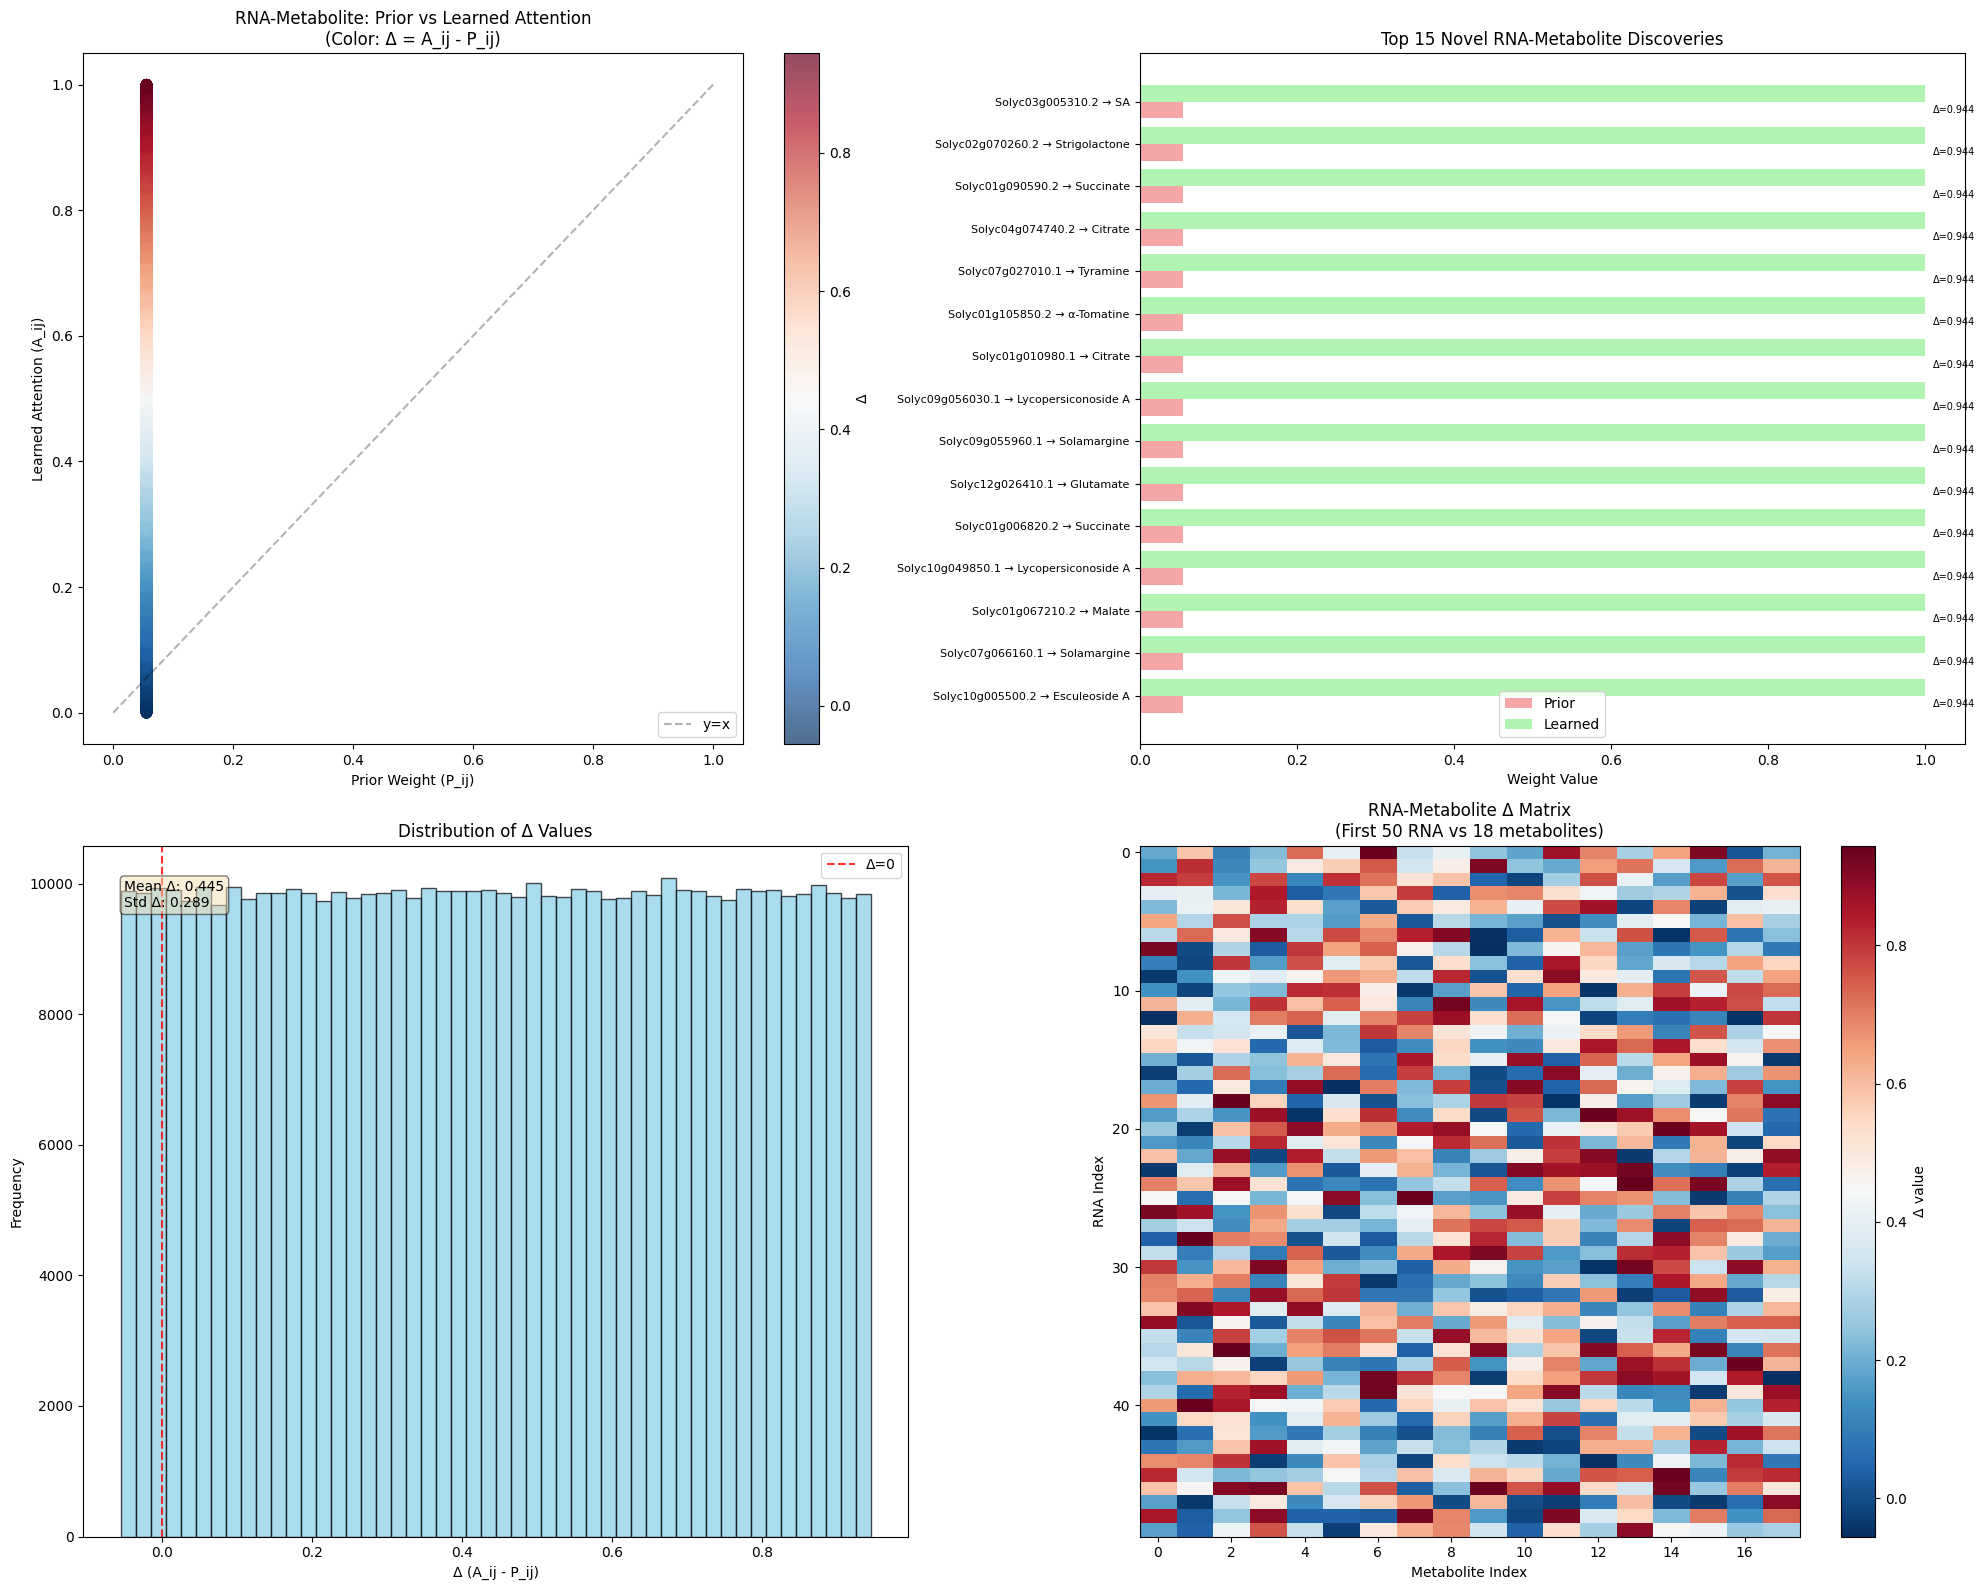

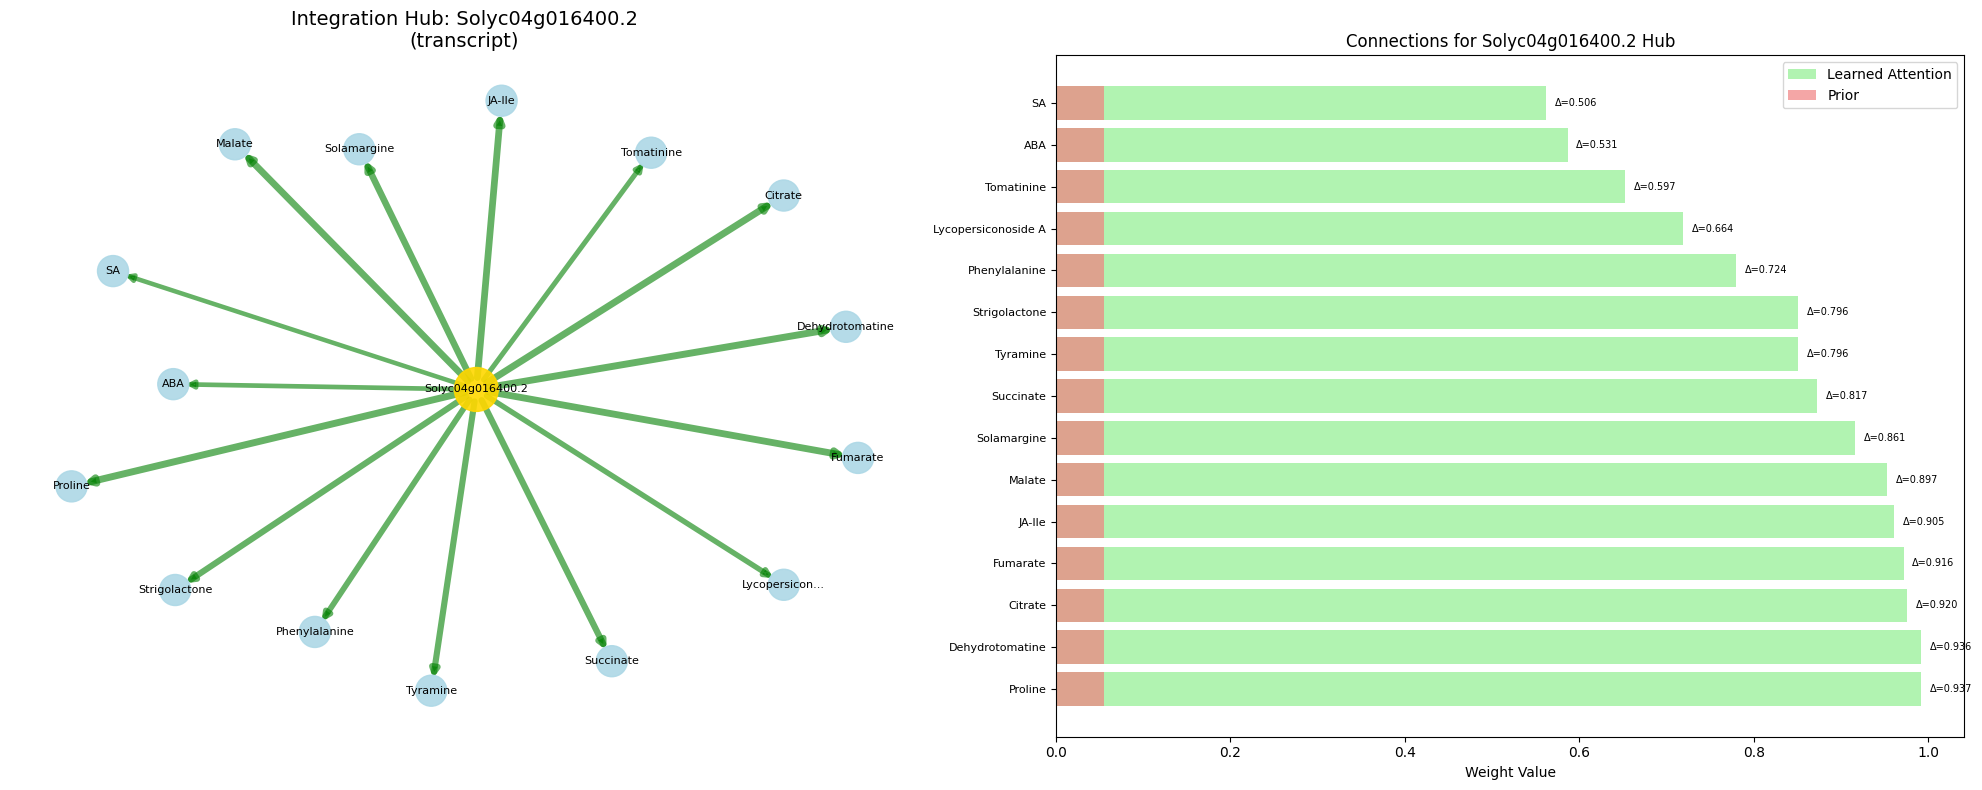

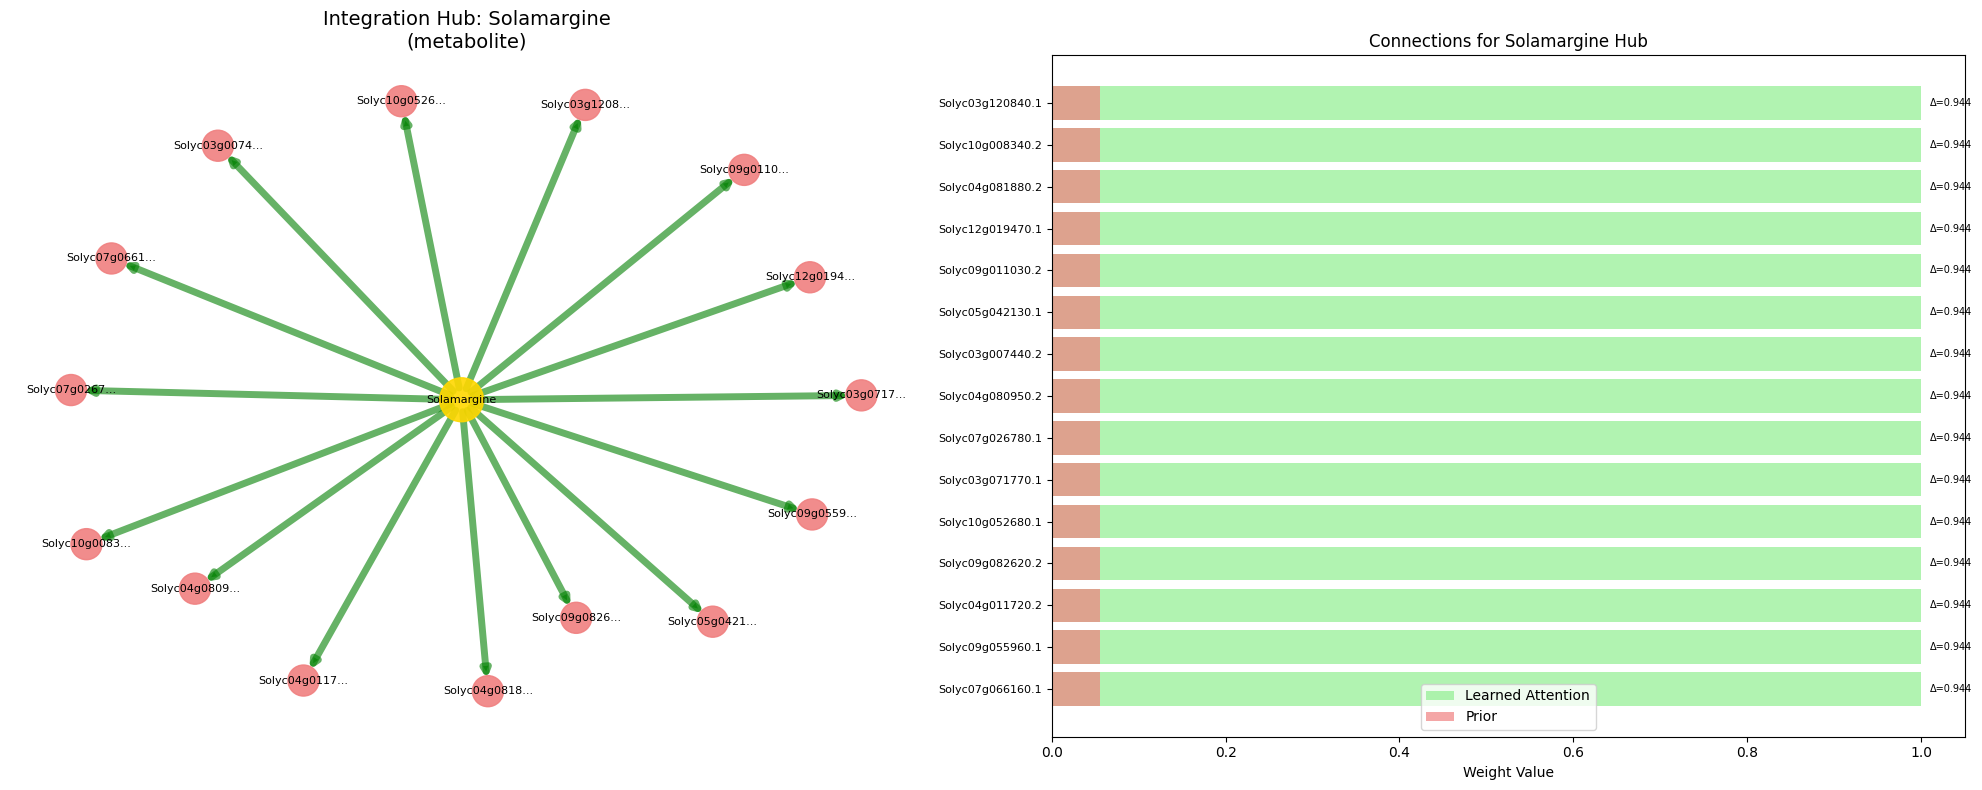

In [40]:
# Run this complete example
import h5py
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# 1. First load environment data
def load_environment_from_h5(h5_file_path):
    with h5py.File(h5_file_path, 'r') as f:
        env_values = f['environment/block0_values'][:]
        env_features = [x.decode('utf-8') for x in f['environment/block0_items'][:]]
        env_samples = [x.decode('utf-8') for x in f['environment/axis1'][:]]

        environment_df = pd.DataFrame(
            env_values,
            index=env_samples,
            columns=env_features
        )
        return environment_df

# Load environment data
h5_file_path = "selected_data_27388.h5"
environment_df = load_environment_from_h5(h5_file_path)
print("Environment data loaded successfully!")
print(f"Shape: {environment_df.shape}")
print(f"Columns: {environment_df.columns.tolist()}")

# 2. Now run the analysis
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Your model should be loaded as 'model'
# model = your_loaded_model

# Run the analysis
results = run_attention_analysis(model, h5_file_path, device)

# Save figures
results['figures']['delta_analysis'].savefig('delta_analysis.png', dpi=300, bbox_inches='tight')
if results['figures']['rna_hub']:
    results['figures']['rna_hub'].savefig('rna_integration_hub.png', dpi=300, bbox_inches='tight')
if results['figures']['metabo_hub']:
    results['figures']['metabo_hub'].savefig('metabo_integration_hub.png', dpi=300, bbox_inches='tight')

print("\nAll results saved!")

In [20]:
import h5py
import pandas as pd
import numpy as np

def load_h5_data(filename):
    """
    Load multi-omics data from H5 file and convert to pandas DataFrames
    """
    data_dict = {}

    with h5py.File(filename, 'r') as f:
        # Load Environment data
        env_group = f['environment']
        env_columns = [col.decode('utf-8') for col in env_group['axis0'][:]]  # Feature names
        env_index = [idx.decode('utf-8') for idx in env_group['axis1'][:]]    # Sample names
        env_data = env_group['block0_values'][:]
        data_dict['environment'] = pd.DataFrame(env_data, index=env_index, columns=env_columns)

        # Load Metabolomics data
        metab_group = f['metabolomics']
        metab_columns = [col.decode('utf-8') for col in metab_group['axis0'][:]]
        metab_index = [idx.decode('utf-8') for idx in metab_group['axis1'][:]]
        metab_data = metab_group['block0_values'][:]
        data_dict['metabolomics'] = pd.DataFrame(metab_data, index=metab_index, columns=metab_columns)

        # Load Phenomics data
        pheno_group = f['phenomics']
        pheno_columns = [col.decode('utf-8') for col in pheno_group['axis0'][:]]
        pheno_index = [idx.decode('utf-8') for idx in pheno_group['axis1'][:]]
        pheno_data = pheno_group['block0_values'][:]
        data_dict['phenomics'] = pd.DataFrame(pheno_data, index=pheno_index, columns=pheno_columns)

        # Load Transcriptome data (be careful with memory due to large size)
        transcript_group = f['transcriptome']
        transcript_columns = [col.decode('utf-8') for col in transcript_group['axis0'][:]]
        transcript_index = [idx.decode('utf-8') for idx in transcript_group['axis1'][:]]
        transcript_data = transcript_group['block0_values'][:]
        data_dict['transcriptome'] = pd.DataFrame(transcript_data, index=transcript_index, columns=transcript_columns)

    return data_dict

# Load the data
data = load_h5_data('selected_data_27388.h5')

# Access individual datasets
environment_df = data['environment']
metabolomics_df = data['metabolomics']
phenomics_df = data['phenomics']
transcriptome_df = data['transcriptome']

print("Dataset shapes:")
print(f"Environment: {environment_df.shape}")
print(f"Metabolomics: {metabolomics_df.shape}")
print(f"Phenomics: {phenomics_df.shape}")
print(f"Transcriptome: {transcriptome_df.shape}")

Dataset shapes:
Environment: (16, 5)
Metabolomics: (16, 18)
Phenomics: (16, 7)
Transcriptome: (16, 27388)


In [86]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def create_effector_groups(labels, effector_names):
    """
    Create effector groups based on actual labels in dataset
    """
    effector_groups = {}
    # Map continuous values to categorical indices
    unique_labels = np.unique(labels)
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    for i, label_value in enumerate(unique_labels):
        indices = np.where(labels == label_value)[0].tolist()
        # Use provided effector names if available, otherwise use numeric labels
        effector_name = effector_names[i] if i < len(effector_names) else f"Effector_{i}"
        effector_groups[effector_name] = indices
    return effector_groups, label_to_idx

def leave_one_group_out_validation(model, multimodal_dataset, labels, effector_names, input_dims, feature_names):
    """
    Perform leave-one-group-out cross-validation for multimodal data
    """
    print("Performing Leave-One-Group-Out Cross-Validation...")
    print("=" * 60)

    effector_groups, label_to_idx = create_effector_groups(labels, effector_names)
    f1_scores = []
    all_predictions = []
    all_true_labels = []

    for test_effector in effector_groups.keys():
        test_indices = effector_groups[test_effector]
        train_indices = []

        for effector, indices in effector_groups.items():
            if effector != test_effector:
                train_indices.extend(indices)

        print(f"Testing on {test_effector}: Training on {len(train_indices)} samples, "
              f"Testing on {len(test_indices)} samples")

        # Create subset datasets
        train_subset = torch.utils.data.Subset(multimodal_dataset, train_indices)
        test_subset = torch.utils.data.Subset(multimodal_dataset, test_indices)

        # Create data loaders
        train_loader = torch.utils.data.DataLoader(
            train_subset, batch_size=2, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_subset, batch_size=4, shuffle=False
        )

        # Train and evaluate - create new model instance for each fold
        fold_model = initialize_model_like_original(model.__class__, input_dims, feature_names)
        trained_model = train_fold_model_simple(fold_model, train_loader, epochs=30)

        test_f1, test_preds, test_true = evaluate_model_simple(trained_model, test_loader, return_predictions=True)
        f1_scores.append(test_f1)
        all_predictions.extend(test_preds)
        all_true_labels.extend(test_true)

        print(f"  True labels in test set: {test_true}")
        print(f"  Predictions in test set: {test_preds}")
        print(f"  F1-score for {test_effector}: {test_f1:.3f}\n")

    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_true_labels, all_predictions, target_names=list(effector_groups.keys())))

    print("Leave-One-Group-Out Results:")
    print(f"Mean F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
    print(f"Individual scores: {[f'{score:.3f}' for score in f1_scores]}")

    return f1_scores, effector_groups

def permutation_test(model_class, multimodal_dataset, labels, input_dims, feature_names, effector_names, n_permutations=50):
    """
    Perform permutation test for multimodal data
    """
    print("\nPerforming Permutation Test...")
    print("=" * 60)

    # First get original performance
    original_model = initialize_model_like_original(model_class, input_dims, feature_names)

    # Split original data
    train_idx, test_idx = train_test_split(
        range(len(multimodal_dataset)), test_size=0.25, stratify=labels, random_state=42
    )

    train_subset = torch.utils.data.Subset(multimodal_dataset, train_idx)
    test_subset = torch.utils.data.Subset(multimodal_dataset, test_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=2, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=4, shuffle=False)

    # Train on original data
    original_model_trained = train_fold_model_simple(original_model, train_loader, epochs=30)
    original_f1, original_preds, original_true = evaluate_model_simple(original_model_trained, test_loader, return_predictions=True)

    print(f"Original test set - True: {original_true}, Pred: {original_preds}")

    # Now do permutations
    permuted_f1_scores = []

    for i in range(n_permutations):
        # Create permuted labels
        permuted_labels = shuffle(labels, random_state=i)

        # Create new dataset with permuted labels
        permuted_dataset = create_permuted_multimodal_dataset(multimodal_dataset, permuted_labels)

        # Split permuted data
        train_subset_perm = torch.utils.data.Subset(permuted_dataset, train_idx)
        test_subset_perm = torch.utils.data.Subset(permuted_dataset, test_idx)

        train_loader_perm = torch.utils.data.DataLoader(train_subset_perm, batch_size=2, shuffle=True)
        test_loader_perm = torch.utils.data.DataLoader(test_subset_perm, batch_size=4, shuffle=False)

        # Train on permuted data
        perm_model = initialize_model_like_original(model_class, input_dims, feature_names)
        trained_perm_model = train_fold_model_simple(perm_model, train_loader_perm, epochs=30)

        # Evaluate on permuted test set
        perm_f1, _, _ = evaluate_model_simple(trained_perm_model, test_loader_perm, return_predictions=True)
        permuted_f1_scores.append(perm_f1)

        if (i + 1) % 10 == 0:
            print(f"  Completed {i + 1}/{n_permutations} permutations...")

    # Calculate significance
    permuted_mean = np.mean(permuted_f1_scores)
    permuted_std = np.std(permuted_f1_scores)
    p_value = np.sum(np.array(permuted_f1_scores) >= original_f1) / n_permutations

    print(f"\nPermutation Test Results:")
    print(f"Original F1-score: {original_f1:.3f}")
    print(f"Permuted F1-scores: {permuted_mean:.3f} ± {permuted_std:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Significant at p < 0.05: {p_value < 0.05}")

    return original_f1, permuted_f1_scores, p_value

def create_permuted_multimodal_dataset(original_dataset, permuted_labels):
    """
    Create a new multimodal dataset with permuted labels
    """
    class PermutedMultimodalDataset(torch.utils.data.Dataset):
        def __init__(self, original_dataset, permuted_labels):
            self.original_dataset = original_dataset
            self.permuted_labels = permuted_labels

        def __len__(self):
            return len(self.original_dataset)

        def __getitem__(self, idx):
            # Get original data (assuming it's a dictionary from your CoMMH5Dataset)
            original_data = self.original_dataset[idx]

            # Create new sample with permuted label but same features
            if isinstance(original_data, dict):
                new_sample = original_data.copy()
                new_sample['target'] = torch.LongTensor([self.permuted_labels[idx]])
                return new_sample
            else:
                # Fallback for other data structures
                return original_data

    return PermutedMultimodalDataset(original_dataset, permuted_labels)

def initialize_model_like_original(model_class, input_dims, feature_names):
    """Initialize a new model with same architecture as original"""
    model = model_class(
        input_dims=input_dims,
        feature_names=feature_names
    )
    return model

def train_fold_model_simple(model, train_loader, epochs=30):
    """Simplified training loop for multimodal data with dictionary batches"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0

        for batch_idx, batch_data in enumerate(train_loader):
            # Handle dictionary batches from CoMMH5Dataset
            if isinstance(batch_data, dict):
                rna = batch_data['rna']
                metabo = batch_data['metabo']
                pheno = batch_data['pheno']
                env = batch_data['env']
                target = batch_data['target'].squeeze()  # Remove extra dimension
            else:
                # Fallback for tuple structure
                rna, metabo, pheno, env, target = batch_data
                target = target.squeeze()

            optimizer.zero_grad()

            # Forward pass with all modalities
            output = model(rna, metabo, pheno, env)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

        if epoch % 10 == 0:
            print(f"  Epoch {epoch}, Loss: {total_loss/batch_count:.4f}")

    return model

def evaluate_model_simple(model, data_loader, return_predictions=False):
    """Simplified evaluation for multimodal data with dictionary batches"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data in data_loader:
            # Handle dictionary batches from CoMMH5Dataset
            if isinstance(batch_data, dict):
                rna = batch_data['rna']
                metabo = batch_data['metabo']
                pheno = batch_data['pheno']
                env = batch_data['env']
                target = batch_data['target'].squeeze()  # Remove extra dimension
            else:
                # Fallback for tuple structure
                rna, metabo, pheno, env, target = batch_data
                target = target.squeeze()

            output = model(rna, metabo, pheno, env)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Debug information
    print(f"  Evaluation - Unique true labels: {np.unique(all_labels)}, Unique predictions: {np.unique(all_preds)}")

    # Handle case where there might be only one class in predictions
    if len(np.unique(all_labels)) > 1:
        f1 = f1_score(all_labels, all_preds, average='weighted')
    else:
        # If only one class, F1 is 1.0 if predictions match, 0.0 otherwise
        f1 = 1.0 if np.array_equal(all_labels, all_preds) else 0.0

    if return_predictions:
        return f1, all_preds, all_labels
    else:
        return f1

# Main execution function
def perform_robustness_analyses(multimodal_dataset, labels, model_class, effector_names, input_dims, feature_names):
    """Run all robustness analyses for multimodal data"""

    print("ROBUSTNESS ANALYSIS FOR CoMM-BIP MODEL")
    print("=" * 60)

    # Debug: Check the actual label distribution
    unique_labels = np.unique(labels)
    print(f"Unique labels in dataset: {unique_labels}")
    print(f"Label distribution: {np.bincount(labels.astype(int))}")

    # Initialize a model to get the class (we won't use this for training, just for reference)
    dummy_model = initialize_model_like_original(model_class, input_dims, feature_names)

    # 1. Leave-One-Group-Out Validation
    logo_scores, effector_groups = leave_one_group_out_validation(
        dummy_model, multimodal_dataset, labels, effector_names, input_dims, feature_names
    )

    # 2. Permutation Test
    original_f1, permuted_scores, p_value = permutation_test(
        model_class, multimodal_dataset, labels, input_dims, feature_names, effector_names, n_permutations=20
    )

    return logo_scores, original_f1, permuted_scores, p_value, effector_groups

# Example usage with your actual data
if __name__ == "__main__":
    # You need to define these based on your actual data
    #from your_dataset_module import CoMMH5Dataset  # Your actual dataset class

    # Load your data
    h5_file_path = "selected_data_27388.h5"

    # Load environment data first (as in your previous code)
    def load_environment_from_h5(h5_file_path):
        import h5py
        import pandas as pd
        with h5py.File(h5_file_path, 'r') as f:
            env_values = f['environment/block0_values'][:]
            env_features = [x.decode('utf-8') for x in f['environment/block0_items'][:]]
            env_samples = [x.decode('utf-8') for x in f['environment/axis1'][:]]

            environment_df = pd.DataFrame(
                env_values,
                index=env_samples,
                columns=env_features
            )
            return environment_df

    environment_df = load_environment_from_h5(h5_file_path)

    # Create dataset
    multimodal_dataset = CoMMH5Dataset(h5_file_path, environment_df)

    # Get labels from dataset - these are the continuous values
    labels = np.array([multimodal_dataset.labels[i] for i in range(len(multimodal_dataset))])

    # Define input dimensions and feature names (you need to get these from your data)
    input_dims = {
        'rna': len(multimodal_dataset.rna_features),
        'metabo': len(multimodal_dataset.metabo_features),
        'pheno': len(multimodal_dataset.pheno_features),
        'env': len(multimodal_dataset.env_features)
    }

    feature_names = {
        'rna': multimodal_dataset.rna_features,
        'metabo': multimodal_dataset.metabo_features,
        'pheno': multimodal_dataset.pheno_features,
        'env': multimodal_dataset.env_features
    }

    # Map the continuous values to meaningful effector names
    # The continuous values are: [-1.34, -0.44, 0.44, 1.34]
    # Map them in order to your effector names
    effector_names = ['GLOIN781', 'GLOIN707', 'RiSP749', 'GFP']

    print(f"Label mapping:")
    unique_labels = np.unique(labels)
    for i, label_val in enumerate(unique_labels):
        print(f"  {label_val:.3f} -> {effector_names[i]}")

    # Run analyses
    logo_scores, original_f1, perm_scores, p_val, groups = perform_robustness_analyses(
        multimodal_dataset, labels, CoMM_BIP, effector_names, input_dims, feature_names
    )

    print("\n" + "="*60)
    print("ROBUSTNESS ANALYSIS COMPLETE")
    print("="*60)
    print(f"LOGO CV Mean F1: {np.mean(logo_scores):.3f}")
    print(f"Permutation Test p-value: {p_val:.4f}")


Dataset contains 16 samples
RNA features: 27388
Metabolite features: 18
Phenotype features: 7
Environment features: 5
Found 4 unique effectors: [-1.3416407864998738, -0.4472135954999579, 0.4472135954999579, 1.3416407864998738]
Label mapping:
  0.000 -> GLOIN781
  1.000 -> GLOIN707
  2.000 -> RiSP749
  3.000 -> GFP
ROBUSTNESS ANALYSIS FOR CoMM-BIP MODEL
Unique labels in dataset: [0 1 2 3]
Label distribution: [4 4 4 4]
Performing Leave-One-Group-Out Cross-Validation...
Testing on GLOIN781: Training on 12 samples, Testing on 4 samples
  Epoch 0, Loss: 2.4802
  Epoch 10, Loss: 0.0834
  Epoch 20, Loss: 0.0553
  Evaluation - Unique true labels: [0], Unique predictions: [0 2 3]
  True labels in test set: [np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
  Predictions in test set: [np.int64(2), np.int64(0), np.int64(3), np.int64(2)]
  F1-score for GLOIN781: 0.000

Testing on GLOIN707: Training on 12 samples, Testing on 4 samples
  Epoch 0, Loss: 2.2253
  Epoch 10, Loss: 0.1349
  Epoch 20, L